In [30]:
import os

# Path to the dataset in Kaggle environment
dataset_path = '/kaggle/input/sports-image-classification/dataset/'

# List all files in the dataset directory
file_names = os.listdir(dataset_path)

print(file_names[:5])
print("you dataset is imported succefully ")

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']
you dataset is imported succefully 


In [31]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard,  LearningRateScheduler
import datetime
import os
import cv2
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
print("all imports is successfully imported ")






all imports is successfully imported 


In [32]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
# Part I: Data Preparation

# 1. Load and Describe the Data
# Path to the dataset in Kaggle environment
train_data_path = '/kaggle/input/sports-image-classification/dataset/train.csv'
test_data_path = '/kaggle/input/sports-image-classification/dataset/test.csv'

# Load the CSV files
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
print("the data imported successfully")

the data imported successfully


In [34]:
print("Train CSV Info (8227 images):")
print(train_df.info())
print("\nTrain CSV Head:")
print(train_df.head())
print("\nTest CSV Info (2056 images):")
print(test_df.info())
print("\nTest CSV Head:")
print(test_df.head())

Train CSV Info (8227 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227 entries, 0 to 8226
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  8227 non-null   object
 1   label     8227 non-null   object
dtypes: object(2)
memory usage: 128.7+ KB
None

Train CSV Head:
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket

Test CSV Info (2056 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  2056 non-null   object
dtypes: object(1)
memory usage: 16.2+ KB
None

Test CSV Head:
         image_ID
0  f5e13966e7.jpg
1  6674191b4e.jpg
2  91b5f8b7a9.jpg
3  393119b6d6.jpg
4  1ce5f81578.jpg


In [35]:
image_col = 'image_ID'
label_col = 'label'

In [36]:
print("\nLabel Distribution:")
print(train_df[label_col].value_counts())


Label Distribution:
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


In [37]:
# 2. Clean the Data
print("\nMissing Values in Train CSV:")
print(train_df.isnull().sum())
train_df.dropna(inplace=True)


Missing Values in Train CSV:
image_ID    0
label       0
dtype: int64


In [38]:
print("\nNumber of Duplicates in Train CSV:", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)


Number of Duplicates in Train CSV: 0


In [39]:
def verify_images(df, folder_path):
    missing_images = []
    for idx, row in df.iterrows():
        # Adjusted path to reflect Kaggle input directory
        img_path = os.path.join(folder_path, row[image_col])
        if not os.path.exists(img_path):
            missing_images.append(row[image_col])
    return missing_images

# Correct path to the dataset in Kaggle environment
train_images_folder = '/kaggle/input/sports-image-classification/dataset/train'

# Now call the function to verify images
missing_train_images = verify_images(train_df, train_images_folder)
print("\nMissing Training Images:", len(missing_train_images))


Missing Training Images: 0


In [40]:
# 3. Load Images and Prepare for PCA
IMG_SIZE = 64
CHANNELS = 3  # Set to 3 for RGB; 

In [41]:
def load_images(df, folder_path, img_size=IMG_SIZE, for_pca=True):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(folder_path, row[image_col])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as RGB (3 channels)
        # To use grayscale (1 channel), replace the above line with:
        # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            if CHANNELS == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for consistency
            if for_pca:
                images.append(img.flatten())  # Flatten: 64x64x3 = 12288 for RGB, 64x64x1 = 4096 for grayscale
            else:
                images.append(img)  # Shape: (64, 64, 3) for RGB, (64, 64) for grayscale
            labels.append(row[label_col])
    return np.array(images), np.array(labels)
print("load image function run successfully")

load image function run successfully


In [42]:
X_pca, y = load_images(train_df, '/kaggle/input/sports-image-classification/dataset/train', for_pca=True)
X_cnn, _ = load_images(train_df, '/kaggle/input/sports-image-classification/dataset/train', for_pca=False)
X_cnn = X_cnn.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)  # Shape for CNN: (samples, 64, 64, 3) for RGB
# To use grayscale, ensure CHANNELS = 1 above, and this line will reshape to (samples, 64, 64, 1)

In [ ]:
# 4. PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')

# Display the plot instead of saving it
plt.show()  # This will show the plot


n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components}")
if n_components < X_pca.shape[1] * 0.5:
    print("PCA is useful: Significant dimensionality reduction achieved.")
    pca = PCA(n_components=n_components)
    X_pca_transformed = pca.fit_transform(X_scaled)
else:
    print("PCA is not useful: Most features are needed to explain variance.")
    X_pca_transformed = X_scaled

In [ ]:
# Add PCA Scatter Plot: Project data onto first two components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)  # Shape: (8227, 2)

# Explained variance for the first two components
var_pc1 = pca_2d.explained_variance_ratio_[0] * 100
var_pc2 = pca_2d.explained_variance_ratio_[1] * 100

# Create a scatter plot, coloring by sport labels
plt.figure(figsize=(10, 8))
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Use tab10 colormap for distinct colors

for idx, label in enumerate(unique_labels):
    mask = y == label
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                label=label, color=colors(idx), alpha=0.6, s=30)

plt.xlabel(f'Principal Component 1 ({var_pc1:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({var_pc2:.2f}% variance)')
plt.title('PCA: 2D Projection of Sports Images')
plt.legend()
plt.show()

In [43]:
# 5. Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

In [46]:
# Print original and encoded labels
print("Original Labels:", y[:10])  # Print the first 10 original labels
print("Encoded Labels:", y_encoded[:10])  # Print the first 10 encoded labels

# Print a mapping between original labels and encoded values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label to Encoded Value Mapping:", label_mapping)

# If you want to print the reverse mapping (encoded value to original label):
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
print("Encoded Value to Label Mapping:", reverse_label_mapping)


Original Labels: ['Badminton' 'Badminton' 'Badminton' 'Badminton' 'Cricket' 'Tennis'
 'Badminton' 'Swimming' 'Badminton' 'Badminton']
Encoded Labels: [0 0 0 0 1 5 0 4 0 0]
Label to Encoded Value Mapping: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}
Encoded Value to Label Mapping: {0: 'Badminton', 1: 'Cricket', 2: 'Karate', 3: 'Soccer', 4: 'Swimming', 5: 'Tennis', 6: 'Wrestling'}


In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_cnn, y_encoded, test_size=0.2, random_state=42)

In [48]:
# Compute the mean and standard deviation for the training set
train_mean = np.mean(X_train, axis=(0, 1, 2))  # Mean for each channel (RGB)
train_std = np.std(X_train, axis=(0, 1, 2))  # Std for each channel (RGB)

# Standardize the data using the mean and std computed from the training set
X_train_standardized = (X_train - train_mean) / train_std
X_val_standardized = (X_val - train_mean) / train_std  # Use the training set's mean and std for validation set

# Define the ImageDataGenerators for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()  # No augmentation for validation set

# Apply the standardization (mean subtraction and division by std) to the train and validation sets
train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=32)


In [49]:
# 5. Check Consistency Between Training and Validation Data Standardization
print("\nEnsure that the training and validation data have similar mean and standard deviation:")
print("Training Mean:", np.mean(X_train_standardized, axis=(0, 1, 2)))
print("Validation Mean:", np.mean(X_val_standardized, axis=(0, 1, 2)))

print("\nTraining Std:", np.std(X_train_standardized, axis=(0, 1, 2)))
print("Validation Std:", np.std(X_val_standardized, axis=(0, 1, 2)))


Ensure that the training and validation data have similar mean and standard deviation:
Training Mean: [-3.73969275e-15 -8.25435816e-14 -1.51779409e-14]
Validation Mean: [-0.01077603 -0.00417199 -0.01862566]

Training Std: [1. 1. 1.]
Validation Std: [0.99881143 1.00159806 0.99471388]


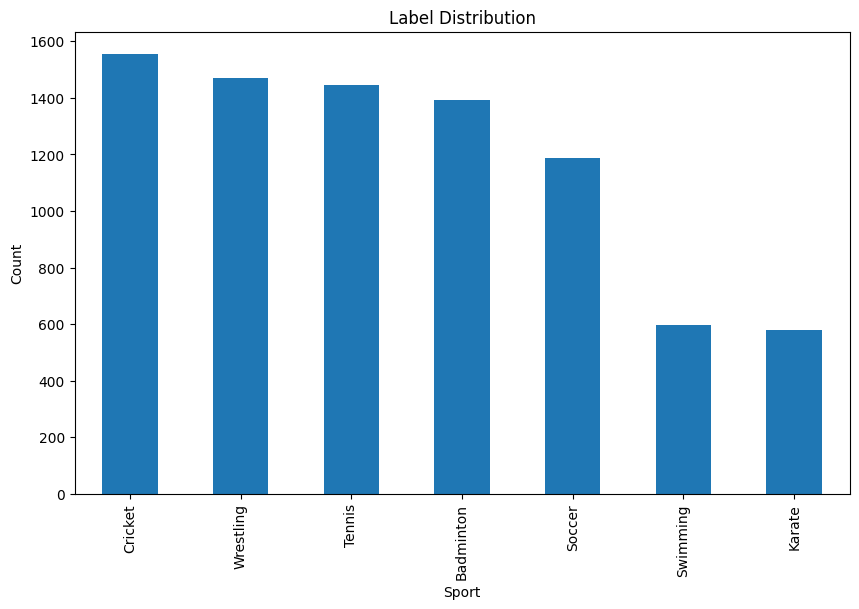

In [50]:
#visualize all data (not train data only )
plt.figure(figsize=(10, 6))
train_df[label_col].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Sport')
plt.ylabel('Count')

# Show the plot in the notebook instead of saving it
plt.show()



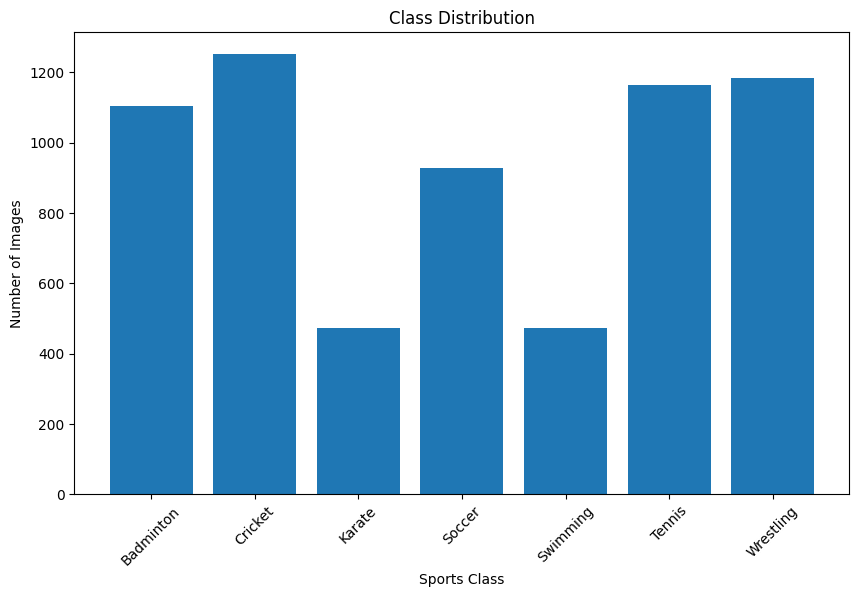

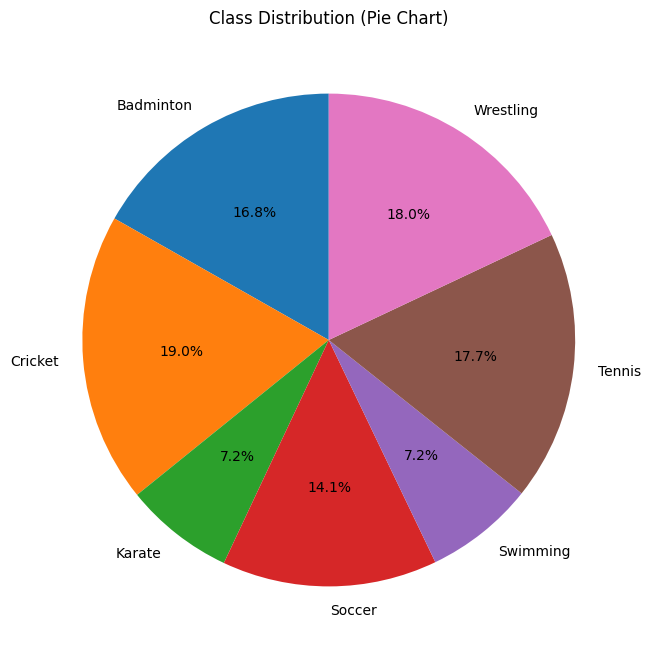

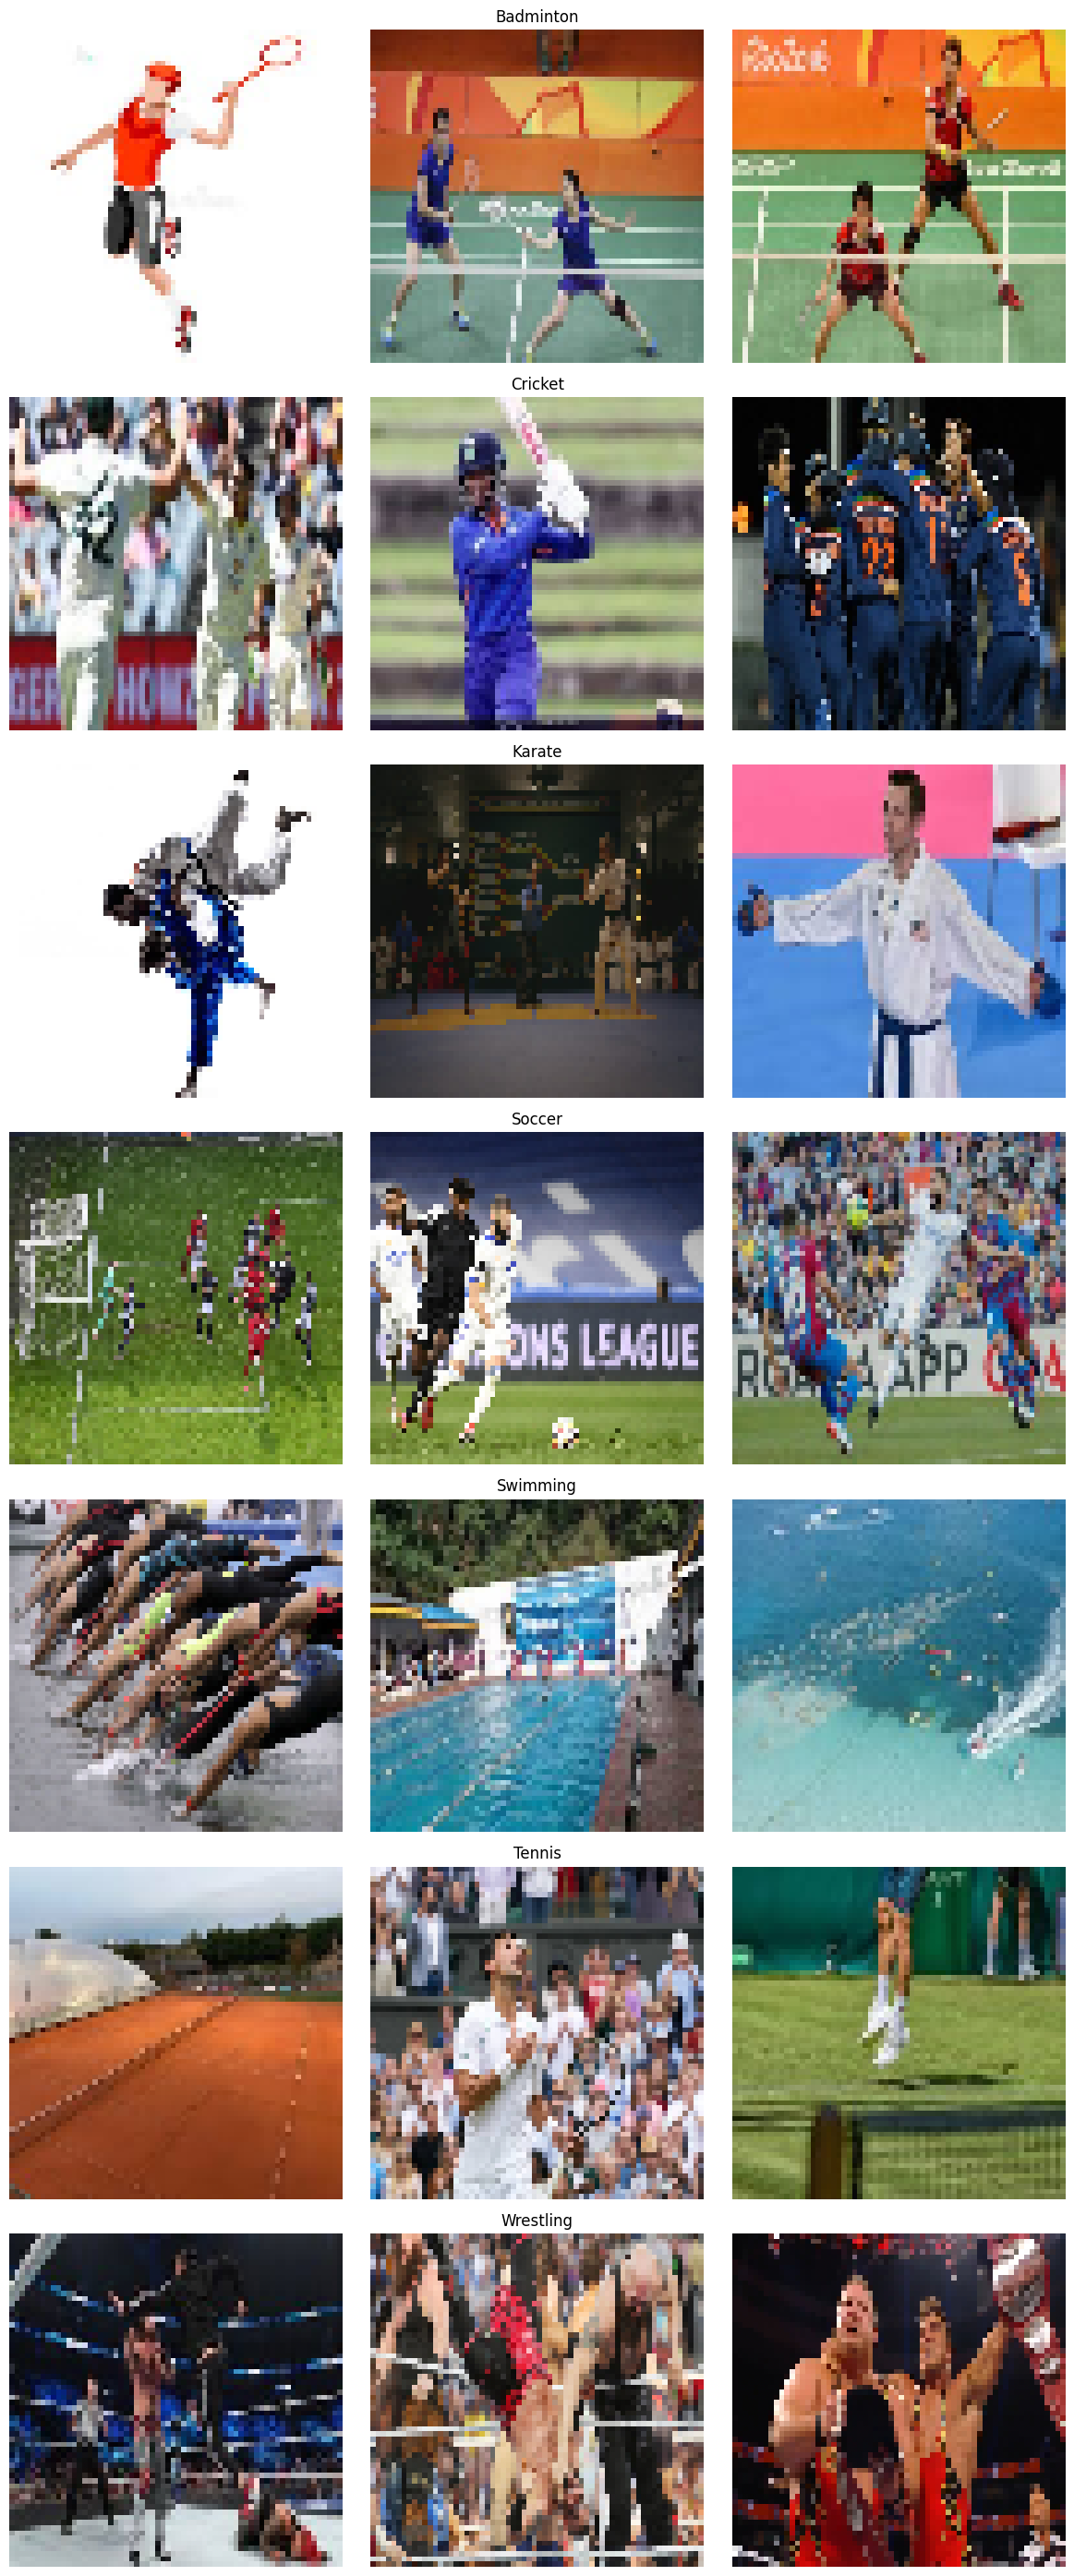

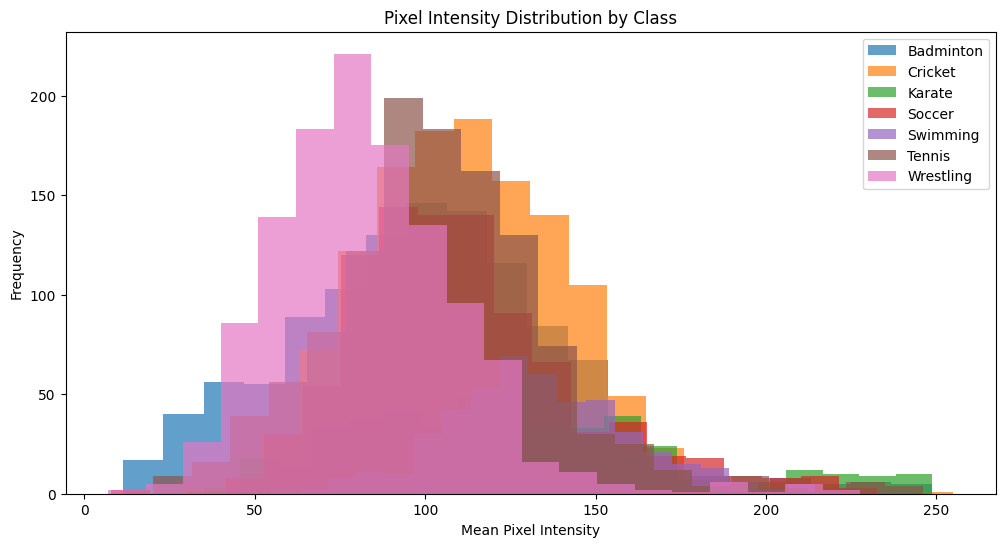

In [51]:
# 8. Visualize Data



def visualize_data(train_images, train_labels, class_names):

    # Label distribution bar chart
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(train_labels, return_counts=True)
    plt.bar(class_names, counts)
    plt.title('Class Distribution')
    plt.xlabel('Sports Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # Pie chart for class distribution
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution (Pie Chart)')
    plt.show()

    # Image montage by class
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 3, figsize=(12, 4 * num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(train_labels == i)[0]
        sample_indices = np.random.choice(class_indices, 3, replace=False)
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(train_images[idx])
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(f'{class_name}')
    plt.tight_layout()
    plt.show()

    # Pixel intensity histograms
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        class_images = train_images[train_labels == i]
        mean_intensities = np.mean(class_images, axis=(1, 2, 3))  # Averaging over the image dimensions
        plt.hist(mean_intensities, bins=20, alpha=0.7, label=class_name)
    plt.title('Pixel Intensity Distribution by Class')
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage
visualize_data(X_train, y_train, class_names)

In [52]:
# 9. Correlation Analysis (Interactive HTML Heatmap with Negative Correlations)
# Compute correlation matrix
pixel_corr = pd.DataFrame(X_pca).iloc[::5, ::5].corr()  # Shape: (2458, 2458)

# Check for negative correlations in the first subsampled matrix
print("\nChecking for negative correlations in first subsampled matrix:")
negative_corrs = pixel_corr[pixel_corr < 0].stack()
if not negative_corrs.empty:
    print(f"Found {len(negative_corrs)} negative correlations. Sample:")
    print(negative_corrs.head())
else:
    print("No negative correlations found.")

# Subsample to reduce size while ensuring negative correlations are included
step = 100  # Reduces from 2458 to ~25 (2458 / 100)
# Select indices to include some negative correlations
# Find pairs with negative correlations
neg_pairs = np.where(pixel_corr < -0.1)  # Threshold to find significant negative correlations
neg_indices = list(set(neg_pairs[0]))  # Unique indices with negative correlations

# Ensure we include some indices with negative correlations
num_indices_to_include = min(5, len(neg_indices))  # Include up to 5 indices with negative correlations
selected_neg_indices = neg_indices[:num_indices_to_include] if neg_indices else []

# Create a list of indices for subsampling, including negative correlation indices
subsample_indices = list(range(0, pixel_corr.shape[0], step))  # Default subsampling: 0, 100, ..., 2400
# Add some indices with negative correlations
for idx in selected_neg_indices:
    closest_subsample_idx = (idx // step) * step  # Align with step
    if closest_subsample_idx not in subsample_indices:
        subsample_indices.append(closest_subsample_idx)

subsample_indices = sorted(set(subsample_indices))  # Remove duplicates and sort
subsample_indices = subsample_indices[:25]  # Limit to 25 indices to keep heatmap manageable

# Subsample the correlation matrix using selected indices
subsampled_corr = pixel_corr.iloc[subsample_indices, subsample_indices].values

# Map subsampled indices back to original indices
original_indices = np.array(subsample_indices) * 5  # Map to original feature space: [0, 500, ..., 12000]

# Create tick labels for the heatmap
num_ticks = min(10, len(original_indices))
tick_positions = np.linspace(0, len(original_indices) - 1, num_ticks).astype(int)
tick_labels = original_indices[tick_positions]

# Create text annotations (rounded correlation values)
text_annotations = np.round(subsampled_corr, 2).astype(str)

# Create interactive heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=subsampled_corr,
    x=original_indices,
    y=original_indices,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlation'),
    text=text_annotations,
    texttemplate="%{text}",
    textfont=dict(size=10),
))

fig.update_layout(
    title='Pixel Correlation Heatmap (Subsampled)',
    xaxis_title='Pixel Index (Subsampled)',
    yaxis_title='Pixel Index (Subsampled)',
    xaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    yaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    autosize=True,
    margin=dict(l=50, r=50, t=100, b=50),
)

fig.write_html(
    'pixel_correlation_interactive.html',
    include_plotlyjs='cdn',
    post_script="""
    const style = document.createElement('style');
    style.innerHTML = `
        #graph { width: 100vw !important; height: 100vh !important; }
        body { margin: 0; padding: 0; overflow: hidden; }
    `;
    document.head.appendChild(style);
    """
)
print("\nInteractive heatmap saved as 'pixel_correlation_interactive.html'")
print("Open the HTML file in a browser to view the full-screen heatmap .")


Checking for negative correlations in first subsampled matrix:
Found 6 negative correlations. Sample:
2635   11835   -0.002409
3020   11835   -0.007049
7960   11835   -0.006249
11835  2635    -0.002409
       3020    -0.007049
dtype: float64

Interactive heatmap saved as 'pixel_correlation_interactive.html'
Open the HTML file in a browser to view the full-screen heatmap .


In [54]:
# Part II: Training a Neural Network

# Requirement 1: Implement a CNN model
def create_cnn_model(input_shape=(224, 224, 3), num_classes=6):
    """
    Creates an enhanced CNN model for sports image classification.
    - Deeper network
    - Batch Normalization
    - Dropout for regularization
    """
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Classification Head
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


# Requirement 2: Write a training function
def train_model(model, optimizer, batch_size, epochs=50):
    """
    Trains the model with early stopping and learning rate scheduling.
    
    Parameters:
    - model: CNN model to train
    - optimizer: Optimizer instance
    - batch_size: Batch size for training
    - epochs: Maximum number of epochs
    
    Returns:
    - History object
    """
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # Define the learning rate schedule
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)
    
    # Wrap the schedule to ensure the output is a Python float
    def schedule(epoch):
        lr = lr_schedule(epoch)
        return float(lr)  # Explicitly cast to Python float
    
    lr_scheduler = LearningRateScheduler(schedule)
    
    log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
        verbose=1
    )
    return history

# Requirement 3: Evaluate the model
def evaluate_model(model):
    """
    Evaluates the model on training and validation sets.
    
    Parameters:
    - model: Trained CNN model
    
    Returns:
    - Tuple of (train_accuracy, val_accuracy)
    """
    train_loss, train_acc = model.evaluate(train_generator, verbose=0)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc
def update_generators(batch_size):
    """
    Updates data generators with a new batch size.
    
    Parameters:
    - batch_size: New batch size
    """
    global train_generator, val_generator
    train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=batch_size)


In [ ]:
BEST_PARAMS = {
    'batch_size': 32,          # From your best_batch
    'num_layers': 3,           # From your best_layers (unused in structure)
    'dropout_rate': 0.2,       # From your best_dropout
    'weight_decay': 0.0,       # From your best_wd
    'optimizer': 'Adam',       # From your best_opt
    'learning_rate': 0.001     # Default for Adam
}

# ========= CONFIGURATION =========
IMG_SIZE    = 64
CHANNELS    = 3
NUM_CLASSES = 7   # adjust to your number of sports classes

IMAGE_COL = 'image_ID'
LABEL_COL = 'label'

# Paths in Kaggle environment
TRAIN_IMG_FOLDER = '/kaggle/input/sports-image-classification/dataset/train'
TEST_IMG_FOLDER  = '/kaggle/input/sports-image-classification/dataset/test'
TRAIN_CSV        = '/kaggle/input/sports-image-classification/dataset/train.csv'
TEST_CSV         = '/kaggle/input/sports-image-classification/dataset/test.csv'

# ===== FUNCTIONS DEFINITION =====
def verify_images(df, folder_path):
    missing = []
    for _, row in df.iterrows():
        path = os.path.join(folder_path, row[IMAGE_COL])
        if not os.path.exists(path):
            missing.append(row[IMAGE_COL])
    return missing


def load_images(df, folder_path, img_size=IMG_SIZE):
    imgs, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        labels.append(row[LABEL_COL])
    return np.array(imgs), np.array(labels)


def load_test_images(df, folder_path, img_size=IMG_SIZE):
    imgs = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return np.array(imgs)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=NUM_CLASSES):
    weight_decay = BEST_PARAMS.get('weight_decay', 0.001)

    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Classifier
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def train_model(train_gen, val_gen, class_weight_dict, epochs=50):
    model = create_cnn_model()
    model.compile(
        optimizer=Adam(learning_rate=BEST_PARAMS['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    return model, history


def plot_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# ===== TRAINING PART for model with best hyper parameters =====
# 1) Load and verify training data
train_df = pd.read_csv(TRAIN_CSV)
missing = verify_images(train_df, TRAIN_IMG_FOLDER)
print(f"Missing train images: {len(missing)}")

# 2) Load all images and labels
X_all, y_all_raw = load_images(train_df, TRAIN_IMG_FOLDER)

# 3) Encode labels
le = LabelEncoder()
y_all = le.fit_transform(y_all_raw)

# 4) Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

# 5) Compute class weights
weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(weights))

# 6) Standardize data
train_mean = X_train.mean(axis=(0,1,2))
train_std  = X_train.std(axis=(0,1,2))
X_train_std = (X_train - train_mean) / train_std
X_val_std   = (X_val   - train_mean) / train_std

# 7) Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen  = ImageDataGenerator()

train_gen = train_datagen.flow(
    X_train_std, y_train,
    batch_size=BEST_PARAMS['batch_size']
)
val_gen = val_datagen.flow(
    X_val_std, y_val,
    batch_size=BEST_PARAMS['batch_size']
)

# 8) Train model
model, history = train_model(train_gen, val_gen, class_weight_dict)

# 9) Plot training history
plot_history(history)

In [ ]:
# ===== TESTING & SUBMISSION PART for model with best hyper parameter =====
# 1) Load and standardize test data
test_df = pd.read_csv(TEST_CSV)
X_test = load_test_images(test_df, TEST_IMG_FOLDER)
X_test_std = (X_test - train_mean) / train_std

test_datagen = ImageDataGenerator()
test_gen = test_datagen.flow(
    X_test_std,
    shuffle=False,
    batch_size=BEST_PARAMS['batch_size']
)

# 2) Predict and inspect distribution
preds = model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)
uniq, counts = np.unique(pred_classes, return_counts=True)
print("Prediction distribution:", dict(zip(uniq, counts)))

# 3) Save submission.csv
pred_labels = le.inverse_transform(pred_classes)
submission = pd.DataFrame({
    IMAGE_COL: test_df[IMAGE_COL],
    LABEL_COL: pred_labels
})
submission.to_csv('submission.csv', index=False)

# 4) Save final model
model.save('best_sports_classifier.keras')

# All Steps in more organized way 

# Functions definition

In [76]:
# # ========= INITIAL PARAMETERS =========
BEST_PARAMS = {
    'batch_size': 32,
    'num_layers': 3,           # Not used, but kept for reference
    'dropout_rate': 0.2,       # Optional override
    'weight_decay': 0.001,     # Used in model
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, models, regularizers

mixed_precision.set_global_policy('mixed_float16')

# ========= CONFIGURATION =========
IMG_SIZE = 64
CHANNELS    = 3
NUM_CLASSES = 7
IMAGE_COL   = 'image_ID'
LABEL_COL   = 'label'
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)

# Paths
TRAIN_CSV     = '/kaggle/input/sports-image-classification/dataset/train.csv'
TEST_CSV      = '/kaggle/input/sports-image-classification/dataset/test.csv'
TRAIN_IMG_DIR = '/kaggle/input/sports-image-classification/dataset/train'
TEST_IMG_DIR  = '/kaggle/input/sports-image-classification/dataset/test'

def build_cnn_model(num_layers=3, dropout_rate=0.3, weight_decay=1e-4):
    """
    Builds a custom CNN with variable number of convolutional blocks,
    dropout, and L2 regularization.
    
    Parameters:
    - num_layers: int, number of conv blocks to use (2–5 recommended)
    - dropout_rate: float, dropout rate for regularization
    - weight_decay: float, L2 regularization factor
    
    Returns:
    - Compiled Keras model
    """
    model = models.Sequential()
    model.add(layers.Input(shape=INPUT_SHAPE))

    for i in range(num_layers):
        filters = min(32 * (2 ** i), 256)  # Gradually increase, max out at 256
        model.add(layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                                kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                                kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())  # Optional to replace with GlobalAveragePooling2D
    model.add(layers.Dense(256, activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

print("run")

run


In [67]:
# ===== FUNCTIONS DEFINITION =====
def verify_images(df, folder_path):
    missing = []
    for _, row in df.iterrows():
        path = os.path.join(folder_path, row[IMAGE_COL])
        if not os.path.exists(path):
            missing.append(row[IMAGE_COL])
    return missing


def load_images(df, folder_path, img_size=IMG_SIZE):
    imgs, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        labels.append(row[LABEL_COL])
    return np.array(imgs), np.array(labels)


def load_test_images(df, folder_path, img_size=IMG_SIZE):
    imgs = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return np.array(imgs)


# LOAD & PREPARE

In [68]:
# Load and clean CSV
df = pd.read_csv(TRAIN_CSV)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f"Samples: {len(df)}; Missing: {len(verify_images(df, TRAIN_IMG_DIR))}")

# # Create generators (train/val/test)
# train_gen, val_gen, test_gen = create_generators(
#     TRAIN_CSV, TEST_CSV,
#     TRAIN_IMG_DIR, TEST_IMG_DIR,
#     img_size=IMG_SIZE,
#     batch_size=BEST_PARAMS['batch_size']
# )

# Compute class weights
le = LabelEncoder()
y_labels = le.fit_transform(df['label'])

cw_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
cw = dict(enumerate(cw_values))

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint



Samples: 8227; Missing: 0


In [69]:
# ==== LOAD & PREPARE DATA (SKLEARN SPLIT) ====

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Drop issues
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)

# Load images and labels
X, y = load_images(train_df, TRAIN_IMG_DIR, img_size=IMG_SIZE)

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/Val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42
)

# Normalize
X_train = X_train / 255.0
X_val   = X_val / 255.0

# Test data (optional for later evaluation)
X_test = load_test_images(test_df, TEST_IMG_DIR, img_size=IMG_SIZE)
X_test = X_test / 255.0


In [70]:
# # ==== Augment Training Data Before Hyperparameter Exploration ====
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def augment_images(X, y):
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True
#     )

#     augmented_X, augmented_y = [], []
#     for i in range(len(X)):
#         x = X[i].reshape((1, *X[i].shape))
#         y_val = y[i]
#         for _ in range(4):
#             for batch in datagen.flow(x, batch_size=1):
#                 augmented_X.append(batch[0])
#                 augmented_y.append(y_val)
#                 break

#     augmented_X = np.array(augmented_X)
#     augmented_y = np.array(augmented_y)

#     # Combine original + augmented
#     X_combined = np.concatenate([X, augmented_X], axis=0)
#     y_combined = np.concatenate([y, augmented_y], axis=0)

#     return X_combined, y_combined

# #  Apply to X_train before exploring
# X_train_aug, y_train_aug = augment_images(X_train, y_train)
# print(f"Augmented Exploration Data: {X_train_aug.shape}, Labels: {y_train_aug.shape}")


In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(X, y, img_size=224):
    """
    Applies strong data augmentation to images using ImageDataGenerator,
    then returns the augmented dataset.
    """
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.25,
        height_shift_range=0.25,
        zoom_range=0.3,
        shear_range=0.2,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    aug_iter = datagen.flow(X, y, batch_size=len(X), shuffle=False)
    X_aug, y_aug = next(aug_iter)
    return X_aug, y_aug



In [73]:
# ==== TRAINING FUNCTION (NumPy Version) ====

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def train_model_numpy(model,
                      X_train, y_train,
                      X_val, y_val,
                      optimizer_name='Adam',
                      learning_rate=0.001,
                      class_weight=None,
                      use_scheduler=True,
                      epochs=12,
                      batch_size=32):
    """
    Trains a model on NumPy arrays instead of generators.
    """
    # Optimizer
    optimizer_classes = {
        'Adam': Adam,
        'SGD': SGD,
        'RMSprop': RMSprop
    }
    opt_kwargs = {'learning_rate': learning_rate}
    if optimizer_name == 'SGD':
        opt_kwargs['momentum'] = 0.9
    optimizer = optimizer_classes[optimizer_name](**opt_kwargs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)]
    if use_scheduler:
        callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2))

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )

    best_val_acc = max(history.history['val_accuracy'])

    return best_val_acc, history



 Training with num_layers = 2


I0000 00:00:1746497480.584433      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746497480.585092      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/12


I0000 00:00:1746497488.846771     113 service.cc:148] XLA service 0x7ea340026e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746497488.847587     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746497488.847609     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746497489.591908     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 21/219 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2399 - loss: 3.4499

I0000 00:00:1746497498.873940     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.3978 - loss: 2.7908 - val_accuracy: 0.2826 - val_loss: 3.4089 - learning_rate: 0.0010
Epoch 2/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6190 - loss: 2.0123 - val_accuracy: 0.3555 - val_loss: 2.8759 - learning_rate: 0.0010
Epoch 3/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6965 - loss: 1.7189 - val_accuracy: 0.5490 - val_loss: 2.4095 - learning_rate: 0.0010
Epoch 4/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7460 - loss: 1.5577 - val_accuracy: 0.6964 - val_loss: 1.7560 - learning_rate: 0.0010
Epoch 5/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7873 - loss: 1.4713 - val_accuracy: 0.6818 - val_loss: 1.8208 - learning_rate: 0.0010
Epoch 6/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8119 - loss: 1.3992 - val_accuracy: 0.7619 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 7/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7790 - loss: 1.6733 - val_accur

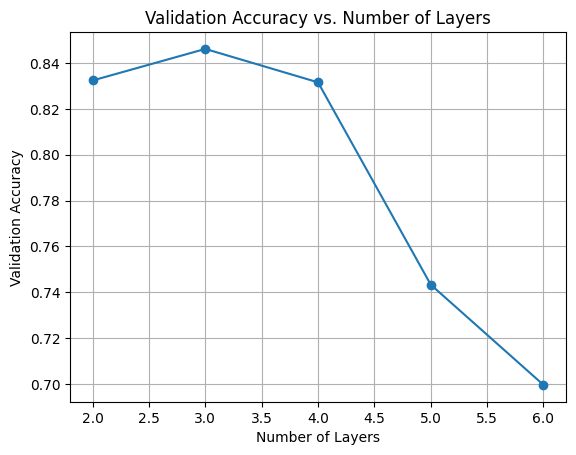


 Best num_layers = 3 with accuracy = 0.8462


In [77]:
# ====  Explore Number of Layers ====

layer_options = [2, 3, 4, 5, 6]
layer_results = {}

for n_layers in layer_options:
    print(f"\n Training with num_layers = {n_layers}")
    
    model = build_cnn_model(
        num_layers=n_layers,
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    layer_results[n_layers] = val_acc

# Plot results
plt.figure()
plt.plot(list(layer_results.keys()), list(layer_results.values()), marker='o')
plt.title('Validation Accuracy vs. Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update best
BEST_PARAMS['num_layers'] = max(layer_results, key=layer_results.get)
print(f"\n Best num_layers = {BEST_PARAMS['num_layers']} with accuracy = {layer_results[BEST_PARAMS['num_layers']]:.4f}")



 Training with dropout_rate = 0.2
Epoch 1/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.3879 - loss: 2.9883 - val_accuracy: 0.2243 - val_loss: 3.0398 - learning_rate: 0.0010
Epoch 2/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5848 - loss: 2.1651 - val_accuracy: 0.4575 - val_loss: 2.6642 - learning_rate: 0.0010
Epoch 3/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6752 - loss: 1.8119 - val_accuracy: 0.5976 - val_loss: 2.1404 - learning_rate: 0.0010
Epoch 4/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7039 - loss: 1.7031 - val_accuracy: 0.3498 - val_loss: 3.7873 - learning_rate: 0.0010
Epoch 5/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7265 - loss: 1.5998 - val_accuracy: 0.7352 - val_loss: 1.5634 - learning_rate: 0.0010
Epoch 6/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7730 - loss: 1.4414 - val_accuracy: 0.6964 - val_loss: 1.7302 - learning_rate: 0.0010
Epoch 7/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

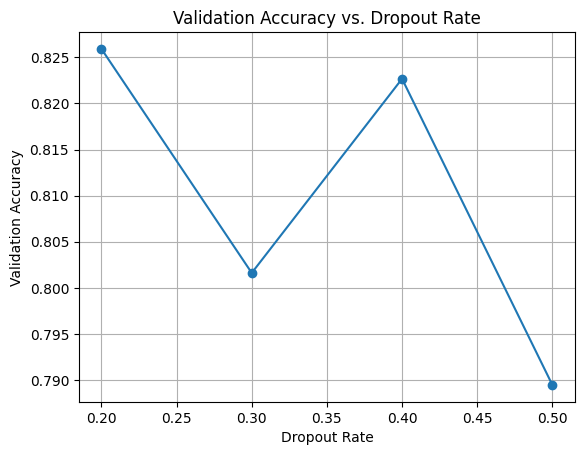


 Best dropout_rate = 0.2 with accuracy = 0.8259


In [78]:
# ==== Explore Dropout Rate ====

dropout_rates = [0.2, 0.3, 0.4, 0.5]
dropout_results = {}

for rate in dropout_rates:
    print(f"\n Training with dropout_rate = {rate}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=rate,
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    dropout_results[rate] = val_acc

# Plot
plt.figure()
plt.plot(dropout_results.keys(), dropout_results.values(), marker='o')
plt.title('Validation Accuracy vs. Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['dropout_rate'] = max(dropout_results, key=dropout_results.get)
print(f"\n Best dropout_rate = {BEST_PARAMS['dropout_rate']} with accuracy = {dropout_results[BEST_PARAMS['dropout_rate']]:.4f}")



 Training with batch_size = 16
Epoch 1/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3787 - loss: 2.9640 - val_accuracy: 0.3328 - val_loss: 2.8186 - learning_rate: 0.0010
Epoch 2/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5601 - loss: 2.2967 - val_accuracy: 0.6073 - val_loss: 1.9843 - learning_rate: 0.0010
Epoch 3/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6427 - loss: 1.8949 - val_accuracy: 0.6858 - val_loss: 1.6939 - learning_rate: 0.0010
Epoch 4/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6727 - loss: 1.7298 - val_accuracy: 0.6656 - val_loss: 1.7160 - learning_rate: 0.0010
Epoch 5/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6930 - loss: 1.6273 - val_accuracy: 0.6478 - val_loss: 1.7987 - learning_rate: 0.0010
Epoch 6/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7551 - loss: 1.4381 - val_accuracy: 0.7393 - val_loss: 1.3634 - learning_rate: 5.0000e-04
Epoch 7/12
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

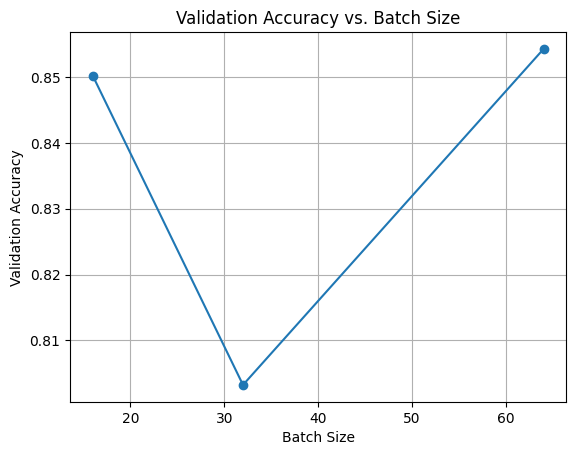


 Best batch_size = 64 with accuracy = 0.8543


In [79]:
# ==== Explore Batch Size ====

batch_sizes = [16, 32, 64]
batch_results = {}

for bs in batch_sizes:
    print(f"\n Training with batch_size = {bs}")

    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=bs
    )

    batch_results[bs] = val_acc

# Plot
plt.figure()
plt.plot(batch_results.keys(), batch_results.values(), marker='o')
plt.title('Validation Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update best batch size
BEST_PARAMS['batch_size'] = max(batch_results, key=batch_results.get)
print(f"\n Best batch_size = {BEST_PARAMS['batch_size']} with accuracy = {batch_results[BEST_PARAMS['batch_size']]:.4f}")



 Training with weight_decay = 0.0
Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.3595 - loss: 2.2022 - val_accuracy: 0.2300 - val_loss: 1.9284 - learning_rate: 0.0010
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6132 - loss: 1.1621 - val_accuracy: 0.2518 - val_loss: 2.2583 - learning_rate: 0.0010
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6914 - loss: 0.9296 - val_accuracy: 0.2024 - val_loss: 2.3622 - learning_rate: 0.0010
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7562 - loss: 0.7213 - val_accuracy: 0.4113 - val_loss: 1.5618 - learning_rate: 5.0000e-04
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7854 - loss: 0.6095 - val_accuracy: 0.6089 - val_loss: 1.1237 - learning_rate: 5.0000e-04
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8244 - loss: 0.5149 - val_accuracy: 0.7644 - val_loss: 0.7169 - learning_rate: 5.0000e-04
Epoch 7/12
110/110 ━━━━━━━━━━━━━━━

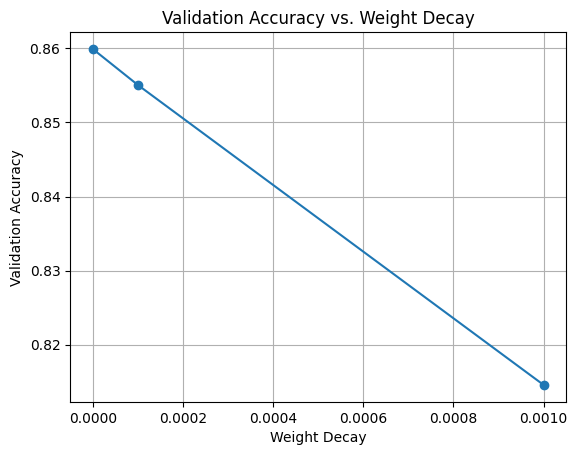


 Best weight_decay = 0.0 with accuracy = 0.8599


In [80]:
# ==== Explore Weight Decay ====

weight_decays = [0.0, 1e-4, 1e-3]
decay_results = {}

for decay in weight_decays:
    print(f"\n Training with weight_decay = {decay}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=decay
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    decay_results[decay] = val_acc

# Plot
plt.figure()
plt.plot(decay_results.keys(), decay_results.values(), marker='o')
plt.title('Validation Accuracy vs. Weight Decay')
plt.xlabel('Weight Decay')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['weight_decay'] = max(decay_results, key=decay_results.get)
print(f"\n Best weight_decay = {BEST_PARAMS['weight_decay']} with accuracy = {decay_results[BEST_PARAMS['weight_decay']]:.4f}")



 Training with optimizer = Adam
Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.3473 - loss: 2.2439 - val_accuracy: 0.2405 - val_loss: 3.8521 - learning_rate: 0.0010
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6140 - loss: 1.1755 - val_accuracy: 0.2866 - val_loss: 2.1747 - learning_rate: 0.0010
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6848 - loss: 0.9176 - val_accuracy: 0.2372 - val_loss: 2.6626 - learning_rate: 0.0010
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7465 - loss: 0.7306 - val_accuracy: 0.4146 - val_loss: 1.6699 - learning_rate: 0.0010
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7849 - loss: 0.6324 - val_accuracy: 0.6599 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8115 - loss: 0.5625 - val_accuracy: 0.7449 - val_loss: 0.7626 - learning_rate: 0.0010
Epoch 7/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

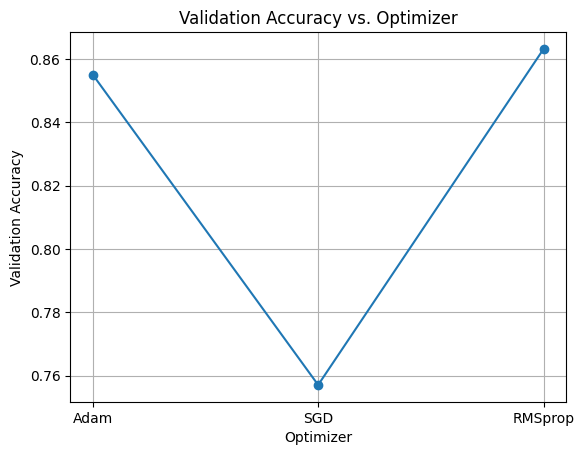


 Best optimizer = RMSprop with accuracy = 0.8632


In [81]:
# ==== Explore Optimizer ====

optimizers = ['Adam', 'SGD', 'RMSprop']
opt_results = {}

for opt in optimizers:
    print(f"\n Training with optimizer = {opt}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=opt,
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    opt_results[opt] = val_acc

# Plot
plt.figure()
plt.plot(opt_results.keys(), opt_results.values(), marker='o')
plt.title('Validation Accuracy vs. Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['optimizer'] = max(opt_results, key=opt_results.get)
print(f"\n Best optimizer = {BEST_PARAMS['optimizer']} with accuracy = {opt_results[BEST_PARAMS['optimizer']]:.4f}")



 Training with learning_rate = 0.0005
Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.3452 - loss: 2.3287 - val_accuracy: 0.1757 - val_loss: 2.6730 - learning_rate: 5.0000e-04
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5922 - loss: 1.2547 - val_accuracy: 0.2138 - val_loss: 2.4651 - learning_rate: 5.0000e-04
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6752 - loss: 0.9751 - val_accuracy: 0.2802 - val_loss: 2.4740 - learning_rate: 5.0000e-04
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7228 - loss: 0.8089 - val_accuracy: 0.4518 - val_loss: 1.9249 - learning_rate: 5.0000e-04
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7713 - loss: 0.6749 - val_accuracy: 0.6462 - val_loss: 1.0807 - learning_rate: 5.0000e-04
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8061 - loss: 0.5685 - val_accuracy: 0.6672 - val_loss: 1.0738 - learning_rate: 5.0000e-04
Epoch 7/12
110/110

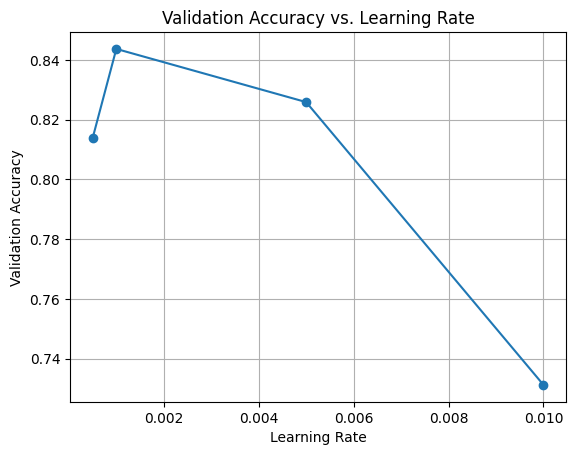


 Best learning_rate = 0.001 with accuracy = 0.8437


In [82]:
# ==== Explore Learning Rate ====

lr_values = [0.0005, 0.001, 0.005, 0.01]
lr_results = {}

for lr in lr_values:
    print(f"\n Training with learning_rate = {lr}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=lr,
        batch_size=BEST_PARAMS['batch_size']
    )

    lr_results[lr] = val_acc

# Plot
plt.figure()
plt.plot(lr_results.keys(), lr_results.values(), marker='o')
plt.title('Validation Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['learning_rate'] = max(lr_results, key=lr_results.get)
print(f"\n Best learning_rate = {BEST_PARAMS['learning_rate']} with accuracy = {lr_results[BEST_PARAMS['learning_rate']]:.4f}")



 Training with scheduler = none
Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.3472 - loss: 2.2572 - val_accuracy: 0.1943 - val_loss: 4.7543
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5739 - loss: 1.3058 - val_accuracy: 0.2494 - val_loss: 2.5417
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6764 - loss: 0.9517 - val_accuracy: 0.2510 - val_loss: 2.2985
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7358 - loss: 0.7522 - val_accuracy: 0.4194 - val_loss: 1.8157
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7906 - loss: 0.6107 - val_accuracy: 0.6688 - val_loss: 0.9589
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8355 - loss: 0.4655 - val_accuracy: 0.7806 - val_loss: 0.6535
Epoch 7/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8736 - loss: 0.3674 - val_accuracy: 0.7838 - val_loss: 0.7673
Epoch 8/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy

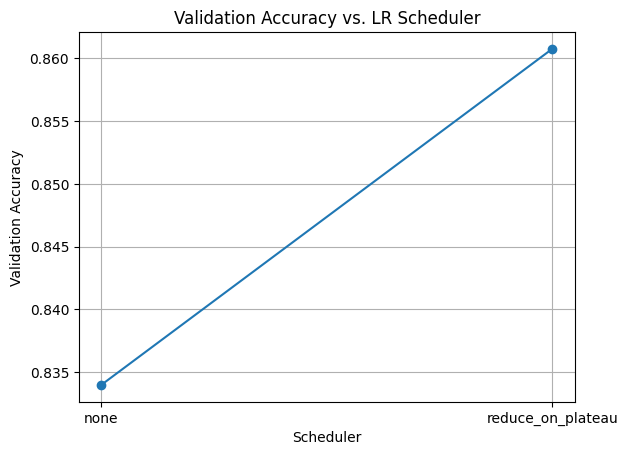


 Best scheduler = reduce_on_plateau with accuracy = 0.8607


In [83]:
# ==== Explore LR Scheduler ====

from tensorflow.keras.callbacks import ReduceLROnPlateau

scheduler_options = {
    'none': None,
    'reduce_on_plateau': ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
}

scheduler_results = {}

for name, sched in scheduler_options.items():
    print(f"\n Training with scheduler = {name}")

    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size'],
        use_scheduler=(sched is not None)
    )

    scheduler_results[name] = val_acc

# Plot
plt.figure()
plt.plot(scheduler_results.keys(), scheduler_results.values(), marker='o')
plt.title('Validation Accuracy vs. LR Scheduler')
plt.xlabel('Scheduler')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update best scheduler
BEST_PARAMS['scheduler'] = max(scheduler_results, key=scheduler_results.get)
print(f"\n Best scheduler = {BEST_PARAMS['scheduler']} with accuracy = {scheduler_results[BEST_PARAMS['scheduler']]:.4f}")


In [84]:
# from tensorflow.keras.losses import CategoricalCrossentropy
# import tensorflow as tf
# import numpy as np

# # Use this as the loss in final training
# loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# def mixup_data(X, y, alpha=0.2):
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
#     else:
#         lam = 1
#     batch_size = X.shape[0]
#     index = np.random.permutation(batch_size)

#     mixed_X = lam * X + (1 - lam) * X[index]
#     y_onehot = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
#     y_shuffled = tf.keras.utils.to_categorical(y[index], num_classes=NUM_CLASSES)
#     mixed_y = lam * y_onehot + (1 - lam) * y_shuffled

#     return mixed_X, mixed_y


In [ ]:
# def get_augmented_generators(train_csv, test_csv, train_dir, test_dir,
#                              img_size=224, batch_size=32, val_split=0.15):
#     """
#     Augmented generator with rotation, shift, zoom, flip for final training.
#     """
#     train_df = pd.read_csv(train_csv)
#     test_df = pd.read_csv(test_csv)

#     train_aug = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         validation_split=val_split
#     )

#     test_datagen = ImageDataGenerator(rescale=1./255)

#     train_gen = train_aug.flow_from_dataframe(
#         dataframe=train_df,
#         directory=train_dir,
#         x_col='image_ID',
#         y_col='label',
#         target_size=(img_size, img_size),
#         class_mode='sparse',
#         batch_size=batch_size,
#         subset='training',
#         shuffle=True
#     )

#     val_gen = train_aug.flow_from_dataframe(
#         dataframe=train_df,
#         directory=train_dir,
#         x_col='image_ID',
#         y_col='label',
#         target_size=(img_size, img_size),
#         class_mode='sparse',
#         batch_size=batch_size,
#         subset='validation',
#         shuffle=True
#     )

#     test_gen = test_datagen.flow_from_dataframe(
#         dataframe=test_df,
#         directory=test_dir,
#         x_col='image_ID',
#         target_size=(img_size, img_size),
#         class_mode=None,
#         batch_size=1,
#         shuffle=False
#     )

#     return train_gen, val_gen, test_gen


In [ ]:
# def final_model, history = final_train_with_mixup(
#     model,
#     X_train, y_train, X_val, y_val,
#     optimizer_name=BEST_PARAMS['optimizer'],
#     learning_rate=BEST_PARAMS['learning_rate'],
#     batch_size=BEST_PARAMS['batch_size'],
#     epochs=60
# )

    

#     opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[optimizer_name]
#     opt_kwargs = {'learning_rate': learning_rate}
#     if optimizer_name == 'SGD':
#         opt_kwargs['momentum'] = 0.9
#     optimizer = opt_cls(**opt_kwargs)

#     model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

#     callbacks = [
#         EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
#         ModelCheckpoint('final_model_mixup.keras', monitor='val_accuracy', save_best_only=True)
#     ]
#     if use_scheduler:
#         callbacks.insert(1, ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3))

#     history = []
#     for epoch in range(epochs):
#         print(f"\n Epoch {epoch+1}/{epochs}")
#         X_mixed, y_mixed = mixup_data(X_train, y_train, alpha=0.2)
#         hist = model.fit(
#             X_mixed, y_mixed,
#             validation_data=(X_val, tf.keras.utils.to_categorical(y_val, NUM_CLASSES)),
#             batch_size=batch_size,
#             epochs=1,
#             callbacks=callbacks,
#             verbose=1
#         )
#         history.append(hist.history)

#     return model, history


In [87]:
# ==== Final Training ====
aug_train_dataset = augment_images(X_train, y_train)
# Rebuild model with best hyperparameters
final_model = build_cnn_model(
    num_layers=BEST_PARAMS['num_layers'],
    dropout_rate=BEST_PARAMS['dropout_rate'],
    weight_decay=BEST_PARAMS['weight_decay']
)

# Choose optimizer
opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[BEST_PARAMS['optimizer']]
opt_kwargs = {'learning_rate': BEST_PARAMS['learning_rate']}
if BEST_PARAMS['optimizer'] == 'SGD':
    opt_kwargs['momentum'] = 0.9
optimizer = opt_cls(**opt_kwargs)

# Label smoothing loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile model
final_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('final_model.keras', monitor='val_accuracy', save_best_only=True)
]
if BEST_PARAMS.get('use_scheduler', True):
    callbacks.insert(1, ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3))

# Train
history = final_model.fit(
    X_train, tf.keras.utils.to_categorical(y_train, NUM_CLASSES),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, NUM_CLASSES)),
    batch_size=BEST_PARAMS['batch_size'],
    epochs=40,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.3255 - loss: 2.4462 - val_accuracy: 0.2308 - val_loss: 2.2892 - learning_rate: 0.0010
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5786 - loss: 1.4783 - val_accuracy: 0.2259 - val_loss: 2.3505 - learning_rate: 0.0010
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6534 - loss: 1.2610 - val_accuracy: 0.2680 - val_loss: 2.5270 - learning_rate: 0.0010
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7129 - loss: 1.1227 - val_accuracy: 0.5328 - val_loss: 1.5598 - learning_rate: 0.0010
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7751 - loss: 0.9870 - val_accuracy: 0.7263 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8210 - loss: 0.8940 - val_accuracy: 0.7846 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8676 - loss: 0

In [88]:
# ==== Evaluation ====

val_loss, val_acc = final_model.evaluate(
    X_val, tf.keras.utils.to_categorical(y_val, NUM_CLASSES),
    verbose=1
)
print(f"\n Final Validation Accuracy: {val_acc:.4f}")

# ==== Prediction on Test Set ====
X_test = load_test_images(pd.read_csv(TEST_CSV), TEST_IMG_DIR, img_size=IMG_SIZE)
X_test = X_test / 255.0
preds = final_model.predict(X_test, verbose=1)
pred_labels = np.argmax(preds, axis=1)

# If you have a label encoder used before
final_predictions = le.inverse_transform(pred_labels)

# Save submission (optional)
submission = pd.DataFrame({
    'image_ID': pd.read_csv(TEST_CSV)['image_ID'],
    'predicted_label': final_predictions
})
submission.to_csv('final_predictions.csv', index=False)
print(" Predictions saved to 'final_predictions.csv'")


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9077 - loss: 0.7090 

 Final Validation Accuracy: 0.9028
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 Predictions saved to 'final_predictions.csv'


In [ ]:
# ===== FINAL VALIDATION EVALUATION =====

val_loss, val_acc = final_train_with_mixup.evaluate(val_gen, verbose=0)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


In [ ]:
# ===== TRAINING HISTORY PLOTS =====

def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training results
plot_history(history)


In [ ]:
# ===== GENERATE TEST PREDICTIONS =====

# Predict class probabilities
test_preds_probs = final_model.predict(test_gen, verbose=1)

# Take the class with the highest probability
test_preds = test_preds_probs.argmax(axis=1)

# Map back to label names using the label encoder
predicted_labels = le.inverse_transform(test_preds)

# Create submission DataFrame
submission = pd.DataFrame({
    'image_ID': test_gen.filenames,
    'label': predicted_labels
})

submission.to_csv('submission.csv', index=False)
print(" Submission file 'submission.csv' created.")


In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img
sample_indices = random.sample(range(len(test_gen.filenames)), 8)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(sample_indices):
    image_path = os.path.join(TEST_IMG_DIR, test_gen.filenames[idx])
    image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(BEST_PARAMS)

In [ ]:
# ===== TEST PREDICTION & SUBMISSION =====
# Load test metadata
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df_test = pd.read_csv(TEST_CSV)
# Load and preprocess test images
df_test = pd.read_csv(TEST_CSV)
X_test = load_test_images(df_test, TEST_IMG_DIR)
# Standardize using training mean and std
X_test = (X_test - m) / std
# Create test generator
test_gen = ImageDataGenerator().flow(
    X_test,
    shuffle=False,
    batch_size=BEST_PARAMS['batch_size']
)
# Predict
preds = final_model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)
# Map back to original labels
pred_labels = le.inverse_transform(pred_classes)
# Save submission.csv
submission_df = pd.DataFrame({
    IMAGE_COL: df_test[IMAGE_COL],
    LABEL_COL: pred_labels
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' saved.")

In [ ]:
print("all cells successfully trained ")

In [ ]:
import os
from IPython.display import FileLink, display

# Paths (assumed already in /kaggle/working)
model_path = 'best_sports_classifier.keras'
sub_path   = 'submission.csv'
zip_path   = 'output.zip'

# 1) Zip them (if you want one download)
#    - the `-j` flag puts them in the root of the zip without folders
!zip -j {zip_path} {model_path} {sub_path}

# 2) Display download links
display(FileLink(model_path, result_html_prefix=" Download model: "))
display(FileLink(sub_path,   result_html_prefix=" Download submission: "))
display(FileLink(zip_path,   result_html_prefix=" Download both as ZIP: "))
